In [4]:
# !nvidia-smi
# !pip install keras
# !pip install torch
# !pip install tensorflow-gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [5]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10 as cifar
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical as one_hot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
(X_train, y_train), (X_test, y_test) = cifar.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

170508288/170498071 [==============================] - 27s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

X_train[45968]:


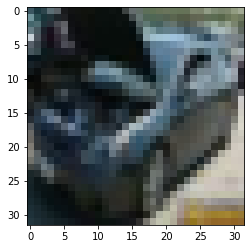

X_train[15868]:


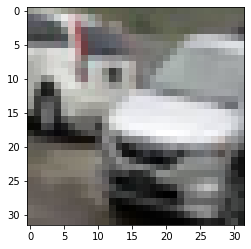

X_train[4562]:


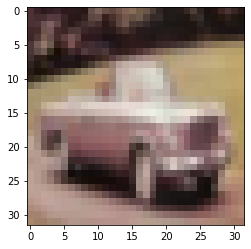

In [7]:
for i in np.random.randint(len(X_train), size=3):
    print(f"X_train[{i}]:")
    plt.imshow(X_train[i] , cmap='gray')
    plt.show()

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the data: using Z-score
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train = (X_train - X_train_mean) / X_train_std + 1e-10 # 1e-10 is to avoid zero division
X_test = (X_test - X_train_mean) / X_train_std + 1e-10

In [9]:
# We need to one-hot encode the labels for the softmax classifier in the output layer
Y_train = one_hot(y_train, 10)
Y_test = one_hot(y_test, 10)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolutional layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

# 3rd convolutional layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

# 4th convolutional layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.55))

# Flatten the output of the convolutional layers into a 1D vector for the fully connected layers
model.add(Flatten())
# Fully connected layer for the final classification
model.add(Dense(10, activation='softmax'))

2021-12-18 02:04:21.020219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 02:04:21.021608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 02:04:21.021948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 02:04:21.022220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [12]:
# We perform data augmentation to avoid overfitting
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False)
datagen.fit(X_train)

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(datagen.flow(X_train, Y_train, batch_size=64), epochs=100, steps_per_epoch=X_train.shape[0] // 64, verbose=1, validation_data=(X_test, Y_test))

# Save the model
model.save('cifar10_model.h5')



Epoch 1/100


2021-12-18 02:04:39.124303: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2021-12-18 02:04:40.008442: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


781/781 [==============================] - 14s 14ms/step - loss: 2.2007 - accuracy: 0.3729 - val_loss: 1.9756 - val_accuracy: 0.5110
Epoch 2/100
781/781 [==============================] - 11s 14ms/step - loss: 1.7048 - accuracy: 0.4923 - val_loss: 1.3112 - val_accuracy: 0.5908
Epoch 3/100
781/781 [==============================] - 10s 13ms/step - loss: 1.4303 - accuracy: 0.5681 - val_loss: 1.2318 - val_accuracy: 0.6230
Epoch 4/100
781/781 [==============================] - 10s 13ms/step - loss: 1.2491 - accuracy: 0.6221 - val_loss: 1.1449 - val_accuracy: 0.6642
Epoch 5/100
781/781 [==============================] - 10s 13ms/step - loss: 1.1795 - accuracy: 0.6550 - val_loss: 0.9890 - val_accuracy: 0.7151
Epoch 6/100
781/781 [==============================] - 10s 13ms/step - loss: 1.1070 - accuracy: 0.6839 - val_loss: 1.0310 - val_accuracy: 0.7059
Epoch 7/100
781/781 [==============================] - 10s 13ms/step - loss: 1.0630 - accuracy: 0.7037 - val_loss: 1.0432 - val_accuracy: 0.71

In [14]:
# Evaluate the model
loss, acc = model.evaluate(X_test, Y_test, verbose=0)

# Print the results
print("\nLoss: %.3f" % loss)
print("Accuracy: %.3f" % acc)


Loss: 0.657
Accuracy: 0.865
